In [39]:
!unzip -q "/content/Air_dataset.zip" -d "/content/dataset"  #unziping
!mv /content/dataset/Air_dataset/* /content/dataset/ #moving file to main folder
!rm -r /content/dataset/Air_dataset


mv: cannot move '/content/dataset/Air_dataset/Bearing' to '/content/dataset/Bearing': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/Flywheel' to '/content/dataset/Flywheel': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/Healthy' to '/content/dataset/Healthy': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/LIV' to '/content/dataset/LIV': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/LOV' to '/content/dataset/LOV': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/NRV' to '/content/dataset/NRV': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/Piston' to '/content/dataset/Piston': Directory not empty
mv: cannot move '/content/dataset/Air_dataset/Riderbelt' to '/content/dataset/Riderbelt': Directory not empty


In [40]:
import os
base_path = "/content/dataset"
print(os.listdir(base_path))


['Flywheel', 'LOV', 'LIV', 'Piston', 'Bearing', 'Healthy', 'Riderbelt', 'NRV']


In [41]:
import os

folder = "/content/dataset/Healthy"
sample_file = os.path.join(folder, os.listdir(folder)[0])

with open(sample_file, 'r') as f:
    lines = f.readlines()

# to see first few lines
print("File:", sample_file)
print("Preview:")
for line in lines[:5]:
    print(line.strip())


File: /content/dataset/Healthy/preprocess_Reading189.dat
Preview:
-0.067348,-0.061085,-0.05391,-0.036546,-0.010511,0.026906,0.075114,0.12524,0.16273,0.17659,0.16617,0.13982,0.10879,0.083406,0.072427,0.081672,0.11109,0.15388,0.19969,0.23885,0.26541,0.27993,0.2923,0.31916,0.37303,0.45085,0.53357,0.59755,0.62685,0.6179,0.57873,0.52648,0.48129,0.45614,0.45016,0.45202,0.44948,0.43612,0.41237,0.38302,0.35368,0.32777,0.30616,0.28874,0.27523,0.26517,0.25797,0.25206,0.24301,0.22423,0.19152,0.14549,0.088265,0.021185,-0.051204,-0.11751,-0.16471,-0.18745,-0.19057,-0.18485,-0.18329,-0.19815,-0.23434,-0.28409,-0.33223,-0.36904,-0.39601,-0.41974,-0.44331,-0.46408,-0.47629,-0.47529,-0.4628,-0.4498,-0.45142,-0.4754,-0.51437,-0.54925,-0.55991,-0.53474,-0.47415,-0.38911,-0.29756,-0.22084,-0.17913,-0.18434,-0.23186,-0.29756,-0.34592,-0.34712,-0.29249,-0.19767,-0.092041,-0.0023542,0.059108,0.096242,0.12121,0.14279,0.15958,0.16299,0.14661,0.11445,0.083469,0.079481,0.12602,0.23003,0.3746,0.52621,0.65083,0.72

In [47]:
# Importing libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.fftpack import dct
import pywt
from scipy.signal import stft
import time
from collections import Counter



# Loading dataset
def load_signal_dataset(root_path):
    X = []
    y = []
    class_map = {}
    class_names = sorted(os.listdir(root_path))
    for idx, class_name in enumerate(class_names):
        class_map[idx] = class_name
        class_path = os.path.join(root_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            if file.endswith(".dat"):
                full_path = os.path.join(class_path, file)
                try:
                    with open(full_path, 'r') as f:
                        line = f.readline()
                        signal = list(map(float, line.strip().split(',')))
                        X.append(signal)
                        y.append(idx)
                except Exception as e:
                    print(f"Error reading {full_path}: {e}")
    return X, y, class_map

# Feature extraction
def extract_features(X):
    feat_list = []
    for signal in X:
        signal = np.array(signal)

        # FFT
        fft_vals = np.abs(np.fft.fft(signal))[:len(signal)//2]
        fft_features = np.mean(fft_vals.reshape(-1, 10), axis=1)[:8]  # trim/pad to fixed size

        # DCT
        dct_vals = dct(signal, norm='ortho')[:40]

        # Wavelet Packet Transform
        wp = pywt.WaveletPacket(signal, 'db1', mode='symmetric', maxlevel=3)
        wp_features = [np.mean(np.abs(node.data)) for node in wp.get_level(3)]

        # STFT
        f, t, Zxx = stft(signal, nperseg=64)
        stft_mag = np.abs(Zxx)
        stft_features = np.mean(stft_mag, axis=1)[:10]

        # Time domain
        mean = np.mean(signal)
        std = np.std(signal)
        kurt = np.mean((signal - mean)**4) / (std**4 + 1e-6)
        skew = np.mean((signal - mean)**3) / (std**3 + 1e-6)

        all_features = np.concatenate([fft_features, dct_vals, wp_features, stft_features, [mean, std, kurt, skew]])
        feat_list.append(all_features)

    return np.array(feat_list)

full_start = time.time()


# Load, extract features, scale
X_raw, y_raw, class_map = load_signal_dataset("/content/dataset")
X_features = extract_features(X_raw)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Feature selection (approximate mRMR)
selector = SelectKBest(mutual_info_classif, k=25)
X_selected = selector.fit_transform(X_scaled, y_raw)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))


# Train and evaluate SVM
clf = SVC(kernel='rbf', C=100, gamma=0.01)
print(f"✅ SVM Params → Kernel: RBF | C: {clf.C} | gamma: {clf.gamma}")

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

start_time = time.time()
y_pred = clf.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time:.2f} seconds")

full_end = time.time()
print(f"Total pipeline time: {full_end - full_start:.2f} seconds")
print(classification_report(y_test, y_pred, target_names=[class_map[i] for i in sorted(class_map)]))

Train class distribution: Counter({4: 180, 1: 180, 3: 180, 0: 180, 6: 180, 7: 180, 5: 180, 2: 180})
Test class distribution: Counter({5: 45, 4: 45, 3: 45, 0: 45, 2: 45, 6: 45, 7: 45, 1: 45})
✅ SVM Params → Kernel: RBF | C: 100 | gamma: 0.01
Training time: 0.03 seconds
Prediction time: 0.01 seconds
Total pipeline time: 48.76 seconds
              precision    recall  f1-score   support

     Bearing       1.00      1.00      1.00        45
    Flywheel       0.98      1.00      0.99        45
     Healthy       1.00      1.00      1.00        45
         LIV       1.00      1.00      1.00        45
         LOV       1.00      0.93      0.97        45
         NRV       1.00      1.00      1.00        45
      Piston       1.00      0.98      0.99        45
   Riderbelt       0.94      1.00      0.97        45

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



In [43]:
# average accuracy across 5 folds
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X_selected, y_raw, cv=5, scoring='accuracy')
print("5‑Fold CV Accuracies:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

5‑Fold CV Accuracies: [0.97777778 0.96111111 0.97222222 0.98888889 0.975     ]
Mean CV Accuracy: 0.975


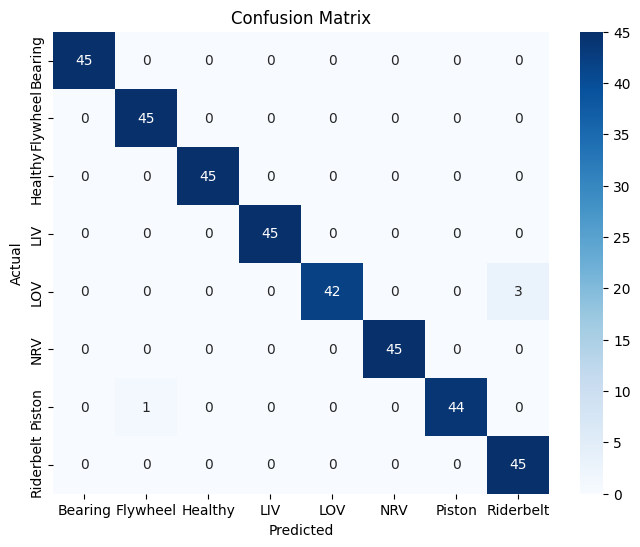

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[class_map[i] for i in sorted(class_map)],
            yticklabels=[class_map[i] for i in sorted(class_map)],
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [45]:
from sklearn.metrics import accuracy_score
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


✅ Test Accuracy: 98.89%
